**PROGETTO DI MODELING OF DISCRETE EVENT SYSTEMS: ASSEGNAZIONE DI UN POD IN AMBIENTE KUBERNETES**

# 1. Esplorazione ed elaborazione dei dati

Per questa fase in particolare, dobbiamo:

* Leggere il file metrics.csv e convertire i suoi dati in array;
* Scalare i dati attraverso la normalizzazione;
* Dividere il nostro set di dati in set di training, set di validazione e set di test;

**Importiamo le librerie**

In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from tensorflow.keras.utils import plot_model

**Caricamento e pulizia dei dati**

In [ ]:
# Dati statici
cores=2000
memory=4015004
kB=1048.58 # per convertire da Mi a kB

lines = list()
df = pd.read_csv('/content/metrics.csv',sep=';')
df.dropna(inplace=True, axis=0,subset = ['CPU (cores)', 'MEMORY (bytes)', 'PARAMETER', 'EXECUTION START TIME (seconds)'])
df

,NAME NODE,CPU (cores),MEMORY (bytes),ACTIVE PODS,TASK,PARAMETER,EXECUTION START TIME (seconds)
0,cs-modeling1,1966m,1623Mi,1,2,2,77126
1,cs-modeling1,374m,1622Mi,1,2,3,77187
2,cs-modeling1,1943m,1646Mi,2,1,2,77256
4,cs-modeling1,1986m,1665Mi,3,2,3,77398
5,cs-modeling1,1980m,1672Mi,2,1,1,77471
...,...,...,...,...,...,...,...
10275,cs-modeling1,1989m,1968Mi,5,1,4,66247
10276,cs-modeling1,1999m,1992Mi,5,2,4,66318
10277,cs-modeling1,1976m,1228Mi,5,1,5,66412
10278,cs-modeling1,1991m,1209Mi,5,1,4,66624


**Normalizzazione**

In [ ]:
for elem in df['CPU (cores)']:
    cpu_old=int(float(elem[0:len(elem)-1])) #Non considero l'unità di misura (m)
    cpu_new=cpu_old/cores 
    if cpu_new>1:
        cpu_new=1.0
    df['CPU (cores)']=df['CPU (cores)'].str.replace(str(cpu_old)+"m", str(cpu_new)[0:5])

for elem in df['MEMORY (bytes)']:
    mem_old=int(float(elem[0:len(elem)-2])) #Non considero l'unità di misura (Mi)
    mem_new=mem_old*kB/memory
    if mem_new>1:
        mem_new=1.0
    df['MEMORY (bytes)']=df['MEMORY (bytes)'].str.replace(str(mem_old)+"Mi", str(mem_new)[0:5])

for elem in df['ACTIVE PODS']:
    oldPods=int(float(elem))
    newPods=int(float(elem))/5
    df['ACTIVE PODS']=df['ACTIVE PODS'].replace(oldPods, newPods)

for elem in df['EXECUTION START TIME (seconds)']:
    oldExec=int(float(elem))
    newExec=int(float(elem))/86400
    df['EXECUTION START TIME (seconds)']=df['EXECUTION START TIME (seconds)'].replace(oldExec, round(newExec, 3))
print(df)

          NAME NODE CPU (cores) MEMORY (bytes)  ACTIVE PODS  TASK  PARAMETER  \
0      cs-modeling1       0.983          0.423          0.2     2          2   
1      cs-modeling1       0.187          0.423          0.2     2          3   
2      cs-modeling1       0.971          0.429          0.4     1          2   
4      cs-modeling1       0.993          0.434          0.6     2          3   
5      cs-modeling1        0.99          0.436          0.4     1          1   
...             ...         ...            ...          ...   ...        ...   
10275  cs-modeling1       0.994          0.513          0.2     1          4   
10276  cs-modeling1       0.999          0.520          0.2     2          4   
10277  cs-modeling1       0.988          0.320          0.2     1          5   
10278  cs-modeling1    1990.000          0.315          0.2     1          4   
10281  cs-modeling1     190.041          0.344          0.2     2          2   

       EXECUTION START TIME (seconds)  

**Individuazione delle features di input (X) e target o valori da predire(Y)**

In [ ]:
X=df['EXECUTION START TIME (seconds)'].values #input
Y=df[['CPU (cores)','MEMORY (bytes)','ACTIVE PODS']].values #target 

print(X,'\n')
print(Y,'\n')

[0.893 0.893 0.894 ... 0.769 0.771 0.774] 

[['0.983' '0.423' 0.2]
 ['0.187' '0.423' 0.2]
 ['0.971' '0.429' 0.4]
 ...
 ['0.988' '0.320' 0.2]
 ['1990.000' '0.315' 0.2]
 ['190.041' '0.344' 0.2]] 



**Split dei dati**

Dalla libreria di Scikit-learn per lo split dei dati usiamo il 'train_test_split', che come suggerisce il nome, divide il nostro set di dati in un set di train e in un set di test. Per prima cosa importiamo la libreria di cui abbiamo bisogno:

In [ ]:
from sklearn.model_selection import train_test_split

Quindi, dividiamo il set di dati in questo modo:

In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3)

Le dimensioni di val_e_test saranno pari al 30% del set di dati complessivo. Il codice memorizzerà i dati divisi nelle prime quattro variabili a sinistra del segno di uguale, come suggeriscono i nomi delle variabili.

Purtroppo, questa funzione ci aiuta solo a dividere il nostro set di dati in due. Poiché vogliamo un insieme di validazione e un insieme di test separati, possiamo usare la stessa funzione per eseguire nuovamente la divisione su val_and_test:

In [ ]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

Il codice precedente dividerà le dimensioni di val_e_test in parti uguali (50%) per l'insieme di validazione e l'insieme di test.

In sintesi, ora abbiamo un totale di sei variabili per i nostri set di dati che utilizzeremo:

* X_train (70% dell'intero set di dati)
* X_val (15% dell'intero set di dati)
* X_test (15% dell'intero set di dati)
* Y_train (70% del dataset completo)
* Y_val (15% del dataset completo)
* Y_test (15% dell'intero set di dati)


Vediamo le dimensioni di ciascun array, è sufficiente eseguire:

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(6960,) (1492,) (1492,) (6960, 3) (1492, 3) (1492, 3)


# 2. Multi-layer Perceptron

Ora dobbiamo descrivere questa architettura alla libreria Keras. Utilizzeremo il modello sequenziale, il che significa che dobbiamo semplicemente descrivere i livelli in sequenza.

Per prima cosa, importiamo il codice necessario dalla libreria Keras:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

**Trasposta dei dati**

In [ ]:
X_train=X_train.T
Y_train=Y_train.T
#print(X_train)
#print(Y_train)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(6960,) (1492,) (1492,) (3, 6960) (1492, 3) (1492, 3)


**Impostare l'architettura della rete neurale: MLP**

Nella nostra architettura di rete abbiamo:

1.   Il livello di input definito sul primo livello intermedio;
2.   Il livello di output

Nello specifico:
*   **Input layer:** 1 neurone;
*   **Hidden layer:** 5 neuroni;
*   **Output layer:** 3 neuroni;

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 10        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


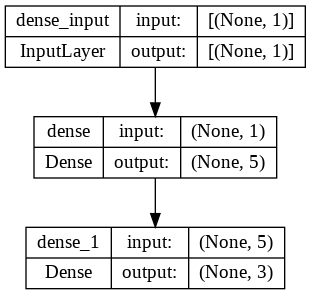

In [ ]:
model = Sequential([
    Dense(5, activation='relu', input_shape=(1,)), 
    Dense(3, activation='sigmoid') 
])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

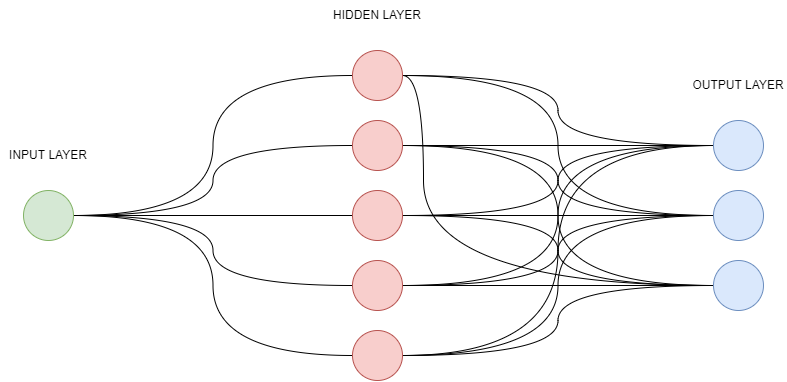


**Configurazione del modello**

Ora che abbiamo specificato la nostra architettura, dobbiamo ottimizzare i valori. Prima di iniziare il training, è necessario configurare il modello, in particolare dobbiamo:

* Indicare l'algoritmo che si vuole utilizzare per l'ottimizzazione;
* La funzione di perdita da utilizzare;
* Le metriche che si vogliono tracciare oltre alla funzione di perdita, nel nostro caso l'accuracy;

Per configurare il modello con queste impostazioni è necessario richiamare la funzione model.compile, in questo modo:

In [ ]:
model.compile(optimizer='adam',
             loss='mse',
             metrics=['accuracy'])

 **Trasformare i record in valori double, poichè TensorFlow non supporta i float**

In [ ]:
X_train = np.asarray(X_train).astype(np.double)
Y_train = np.asarray(Y_train).astype(np.double)
X_val = np.asarray(X_val).astype(np.double)
Y_val = np.asarray(Y_val).astype(np.double)
X_test = np.asarray(X_test).astype(np.double)
Y_test = np.asarray(Y_test).astype(np.double)

**Training dei dati**

La funzione utilizzata per il training è chiamata "fit", poiché stiamo adattando i parametri ai dati. Dobbiamo specificare su quali dati ci stiamo allenando, ovvero X_train e Y_train trasposto. Quindi, si specifica la dimensione del mini-batch, in questo caso 32 e la durata del training (epochs). Infine, specifichiamo quali sono i dati per la validazione, in modo che si veda come il modello reagisce a questi dati in ogni punto. Questa funzione produrrà una cronologia, che salveremo nella variabile hist. Utilizzeremo questa variabile più avanti, quando arriveremo alla visualizzazione. Otterremo: l'andamento della funzione di perdita per il set di dati di training (loss) e validazione (val_loss), l'andamento della metrica accuracy per il set di dati di training (accuracy) e validazione (val_accuracy). 

In [ ]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
hist = model.fit(X_train, Y_train.T,
          batch_size=32, epochs=50,
          validation_data=(X_val, Y_val))

(6960,) (3, 6960) (1492,) (1492, 3)
Epoch 1/50
218/218 [==============================] - 1s 3ms/step - loss: 180275.1250 - accuracy: 0.8698 - val_loss: 190298.0000 - val_accuracy: 0.8760
Epoch 2/50
218/218 [==============================] - 0s 2ms/step - loss: 180253.4844 - accuracy: 0.8698 - val_loss: 190274.1719 - val_accuracy: 0.8760
Epoch 3/50
218/218 [==============================] - 0s 2ms/step - loss: 180231.4531 - accuracy: 0.8698 - val_loss: 190251.2344 - val_accuracy: 0.8760
Epoch 4/50
218/218 [==============================] - 0s 2ms/step - loss: 180210.6875 - accuracy: 0.8698 - val_loss: 190232.0625 - val_accuracy: 0.8760
Epoch 5/50
218/218 [==============================] - 0s 2ms/step - loss: 180194.6875 - accuracy: 0.8698 - val_loss: 190219.6875 - val_accuracy: 0.8760
Epoch 6/50
218/218 [==============================] - 0s 2ms/step - loss: 180185.3750 - accuracy: 0.8698 - val_loss: 190213.4688 - val_accuracy: 0.8760
Epoch 7/50
218/218 [==============================] 

Per trovare l'accuratezza del nostro set di dati di test, eseguiamo la seguente riga di codice. Il motivo per cui abbiamo l'indice 1 dopo la funzione model.evaluate è che la funzione restituisce la perdita come primo elemento e la accuratezza come secondo elemento. Per restituire solo l'accuratezza, è sufficiente accedere al secondo elemento (che è indicizzato con 1, poiché il primo elemento inizia la sua indicizzazione da 0).

In [ ]:
model.evaluate(X_test, Y_test)[1]

47/47 [==============================] - 0s 2ms/step - loss: 164428.3438 - accuracy: 0.8800


0.8800268173217773

**Predizione**

Nella fase di predizione, andiamo a predire i valori di: CPU (cores), MEMORY (bytes) e ACTIVE PODS.

In [ ]:
predicted_y = model.predict(X_test)
print (X_test) #test dataset
print (predicted_y) #predicted values

47/47 [==============================] - 0s 1ms/step
[0.73  0.117 0.375 ... 0.058 0.631 0.761]
[[0.99999994 0.9999986  0.44856483]
 [0.999974   0.9998878  0.44847718]
 [0.9999976  0.9999824  0.44851404]
 ...
 [0.99995506 0.9998286  0.44846874]
 [0.99999976 0.9999972  0.44855067]
 [0.99999994 0.9999989  0.44856924]]


# Visualizzare la funzione di perdita e la metrica dell'accuratezza

Quello che vorremmo fare è tracciare 4 grafici: funzione di perdita riguardante il set di train e funzione di perdita riguardante il set di validazione in base al numero di epoche trascorse. Stessa cosa per la accuratezza. Per la visualizzazione dei grafici, utilizzeremo la libreria matplotlib. Importiamo prima di tutto la libreria:

In [ ]:
import matplotlib.pyplot as plt

Tracciamo la funzione di perdita relativa al set di dati di train e validazione.

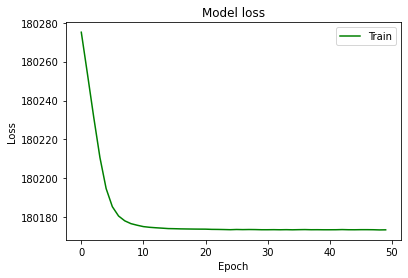

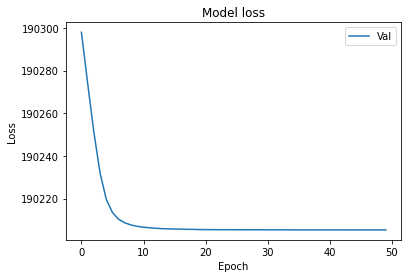

In [ ]:
plt.plot(hist.history['loss'], color="g")
#plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

#plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Val'], loc='upper right')
plt.show()

Possiamo fare lo stesso tracciando l'accuratezza dei dati di training e l'accuratezza dei dati di validazione con il codice seguente:

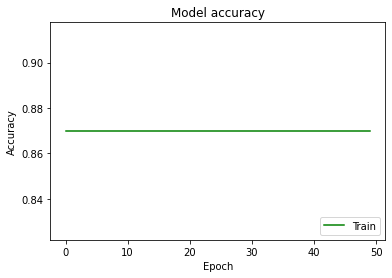

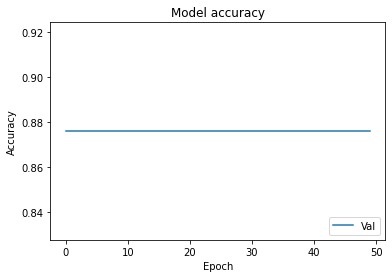

In [ ]:
plt.plot(hist.history['accuracy'], color="g")
#plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

#plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val'], loc='lower right')
plt.show()